## Ubaydullaev Bekhzod U1910300

# Task1

#### U1910300 -> example1.py

In [ ]:
from sightpy import *

# define materials to use
gold_metal = Glossy(diff_color = rgb(0, 1, 0), n = vec3(0.15+3.58j, 0.4+2.37j, 1.54+1.91j), roughness = 0.0, spec_coeff = 0.2, diff_coeff= 0.8) # n = index of refraction
bluish_metal = Glossy(diff_color = rgb(1, 0, 1), n = vec3(1.3+1.91j, 1.3+1.91j, 1.4+2.91j), roughness = 0.2,spec_coeff = 0.5, diff_coeff= 0.3)
green_glass = Refractive(n = vec3(1.5 + 4e-8j,1.5 + 0.j,1.5 + 4e-8j)) 
red_glass = Refractive(n = vec3(1.5 + 0.j,1.5 +  5e-8j,1.5 +  5e-8j))

floor =  Glossy(diff_color = image("noise.png", repeat = 80.),   
	            n = vec3(1.2+ 0.3j, 1.2+ 0.3j, 1.1+ 0.3j), roughness = 0.2, spec_coeff = 0.3, diff_coeff= 0.9 )

# Set Scene 
Sc = Scene(ambient_color = rgb(0.05, 0.05, 0.05))

angle = -np.pi/2 * 0.3
Sc.add_Camera(look_from = vec3(2.5*np.sin(angle), 1.5, 2.5*np.cos(angle)  -1.5 ), 
			  look_at = vec3(0., 0.25, -3.), 
	          screen_width = 400 ,
	          screen_height = 300)

Sc.add_DirectionalLight(Ldir = vec3(0.52,0.45, -0.5),  color = rgb(0.15, 0.15, 0.15))

Sc.add(Sphere(material = gold_metal, center = vec3(-2, .1, -3.),radius =  .6, max_ray_depth = 6))
Sc.add(Cuboid( material = red_glass, center = vec3(-.5, .1, -3.), width = 1.0,height = 1.2, length = 0.8,  max_ray_depth = 6))
Sc.add(Sphere(material = bluish_metal, center = vec3(1.25, .1, -3.),radius =  .6, max_ray_depth = 6))
Sc.add(Cuboid( material = green_glass, center = vec3(2.5, .1, -2), width = 1.0,height = 1.2, length = 0.8,  max_ray_depth = 6))

Sc.add(Plane(material = floor,  center = vec3(0, -0.5, -3.0), width = 120.0,height = 120.0, u_axis = vec3(1.0, 0, 0), v_axis = vec3(0, 0, -1.0),  max_ray_depth = 3))

#see sightpy/backgrounds
Sc.add_Background("miramar.jpeg")

# Render 
img = Sc.render(samples_per_pixel = 6)

img.save("EXAMPLE1.png")

img.show()

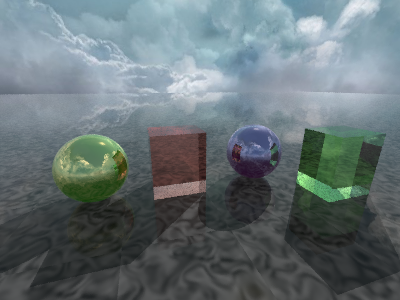

# Task 2

In [1]:
import os, sys
from copy import deepcopy
import numpy as np
import pandas as pd

import torch as th
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
print(f"Torch version: {th.__version__}.  CUDA version: {th.version.cuda}")

Torch version: 2.0.0+cu118.  CUDA version: 11.8


In [4]:
dgl_version = "dgl-cu113==0.7.2"
dgl_version

'dgl-cu113==0.7.2'

In [5]:
# Follow instructions at https://www.dgl.ai/pages/start.html
!{sys.executable} -m pip install {dgl_version} -f https://data.dgl.ai/wheels/repo.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.dgl.ai/wheels/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.9/152.9 MB 8.0 MB/s eta 0:00:00


In [6]:
os.environ['DGLBACKEND'] = 'pytorch'
import dgl
from dgl import function as fn

Using backend: pytorch


In [7]:
dgl.__version__

'0.7.2'

In [8]:
from dgl.dataloading.pytorch import NodeDataLoader

In [9]:
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
device

device(type='cuda')

#### Download training.csv and test.csv from https://zindi.africa/competitions/xente-fraud-detection-challenge/data

In [11]:
df_train = pd.read_csv('training.csv')
df_train['dataset'] = 'train'
df_test = pd.read_csv('test.csv')
df_test['dataset'] = 'test'

In [12]:
df = pd.concat([df_train, df_test], axis=0)

In [14]:
def column_index(series, offset=0):
    return {k: v+offset for v, k in enumerate(series.value_counts().index.values)}

In [15]:
txn2idx = {v: idx for idx, v in enumerate(df['TransactionId'].values)}
acct2idx = column_index(df['AccountId'])
sub2idx = column_index(df['SubscriptionId'])
cust2idx = column_index(df['CustomerId'])

In [16]:
df['txnIdx'] = df['TransactionId'].map(txn2idx)
df = df.sort_values(by='txnIdx')
df['acctIdx'] = df['AccountId'].map(acct2idx)
df['subIdx'] = df['SubscriptionId'].map(sub2idx)
df['custIdx'] = df['CustomerId'].map(cust2idx)

In [17]:
y_txn = df.sort_values(by='txnIdx')['FraudResult'].values
y_txn

array([ 0.,  0.,  0., ..., nan, nan, nan])

In [18]:
baseline = y_txn[y_txn>=0].mean()
baseline

0.00201752001839811

In [19]:
# node_id_cols = ['txnIdx', 'acctIdx', 'subIdx', 'custIdx']
node_id_cols = ['txnIdx', 'subIdx', 'acctIdx']

In [20]:
N_nodes = df[node_id_cols].nunique().sum()
N_nodes

150358

In [21]:
N_labels = df[df['dataset']=='train'].shape[0]

In [22]:
from itertools import combinations

In [23]:
edge_dict = dict()
for src_type, dst_type in combinations(node_id_cols, 2):
    fwd = (src_type, f'{src_type}-{dst_type}', dst_type)
    bwd = (dst_type, f'{dst_type}-{src_type}', src_type)
    print(fwd)
    print(bwd)
    print('-'*50)
    
    edges = df[[src_type, dst_type]].drop_duplicates().values
    src = edges[:,0]
    dst = edges[:,1]

    edge_dict[fwd] = (th.tensor(src), th.tensor(dst))
    edge_dict[bwd] = (th.tensor(dst), th.tensor(src))

('txnIdx', 'txnIdx-subIdx', 'subIdx')
('subIdx', 'subIdx-txnIdx', 'txnIdx')
--------------------------------------------------
('txnIdx', 'txnIdx-acctIdx', 'acctIdx')
('acctIdx', 'acctIdx-txnIdx', 'txnIdx')
--------------------------------------------------
('subIdx', 'subIdx-acctIdx', 'acctIdx')
('acctIdx', 'acctIdx-subIdx', 'subIdx')
--------------------------------------------------


In [24]:
hg = dgl.heterograph(edge_dict)

In [25]:
label_feat = dict()
for ntype in hg.ntypes:
    if ntype=='txnIdx':
        continue
    label_feat[ntype] = th.zeros(hg.number_of_nodes(ntype))+baseline
label_feat['txnIdx'] = th.tensor(np.nan_to_num(y_txn, nan=baseline)).float()

In [26]:
hg.ndata['label'] = label_feat

In [27]:
import networkx as nx

In [76]:
def draw_kkl_hg(hg, count, **kwargs):
    
    hg_label = hg.ndata['label']['txnIdx'].int()
    
    g = dgl.to_homogeneous(hg)
    g.ndata['ntype'] = g.ndata['_TYPE']
    nx_G = g.to_networkx(node_attrs=['ntype']).to_undirected()
    # code for creating 2x2 grid
    plt.subplot(2,2,count)
    
    pos = nx.spring_layout(nx_G, k=5/np.sqrt(g.num_nodes()))
    
    nodeShapes = ["^", "s", "o", "v"]
    for idx, ntype in enumerate(hg.ntypes):
        aShape = nodeShapes[idx]
        if ntype=='txnIdx':
            node_color = ['blue' if v==0 else 'red' if v==1 else 'black' for v in hg_label]
        else:
            node_color = "grey"
        nx.draw_networkx_nodes(
            nx_G, pos, node_shape=aShape, node_color=node_color, cmap='bwr', node_size=200,
            nodelist=[sNode[0] for sNode in filter(lambda x: x[1]["ntype"]==idx, nx_G.nodes(data=True))]
        )

    nx.draw_networkx_edges(nx_G, pos)

def plot_neighborhood(dataloader, N_plots=5):
    nstats = dict()
    # code for creating 2x2 grid
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
    for i in range(0, 2):
      for j in range(0, 2):
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])

    count = 1
    for i, (input_nodes, output_nodes, blocks) in enumerate(dataloader):
        if i >= N_plots:
            break
        hg_tmp = dgl.node_subgraph(hg, input_nodes)
        draw_kkl_hg(hg_tmp, count=count)
        count += 1  

    plt.show()        

def neighborhood_stats(hg):
    def mp_fn_dict(in_feat, out_feat):
        return {
            cetype: (fn.copy_u(in_feat, 'm'), fn.sum('m', out_feat))
            for cetype in hg.canonical_etypes
        }
    
    with hg.local_scope():
        degree_data = dict()
        for ntype in hg.ntypes:
            in_degrees = th.zeros(hg.num_nodes(ntype))
            for cetype in hg.canonical_etypes:
                if cetype[2]==ntype:
#                     print(cetype)
                    in_degrees += hg.in_degrees(etype=cetype)
            degree_data[ntype] = in_degrees

        hg.ndata['degree'] = degree_data
        hg.ndata['N_fraud'] = {
            ntype: (labels==1).float() for ntype, labels in hg.ndata['label'].items()
        }
        
        hg.multi_update_all(mp_fn_dict('degree', 'd_sum'), cross_reducer='sum')
        hg.multi_update_all(mp_fn_dict('N_fraud', 'total_fraud'), cross_reducer='sum')
        hg.multi_update_all(mp_fn_dict('total_fraud', 'total_fraud_2hop'), cross_reducer='sum')
        
        n_2hop = hg.ndata['d_sum']['txnIdx']
        fraud_rate_2hop = hg.ndata['total_fraud_2hop']['txnIdx'] / hg.ndata['d_sum']['txnIdx']
    return n_2hop, fraud_rate_2hop

In [29]:
n_hops = 2
sampler = dgl.dataloading.MultiLayerNeighborSampler([10]*n_hops)

### Random Sample 

In [30]:
dataloader_legit = NodeDataLoader(
    hg, {'txnIdx': np.where(y_txn==0)[0]}, sampler,
    batch_size=1, shuffle=False, drop_last=False, num_workers=0)

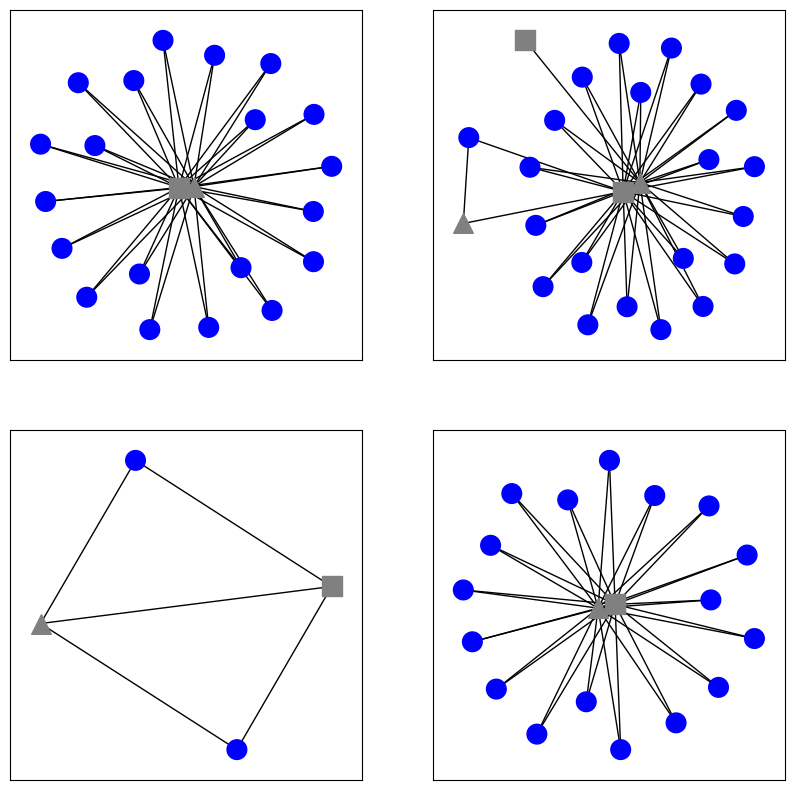

In [77]:
plot_neighborhood(dataloader_legit, N_plots=4)

### Known Fraud

In [78]:
dataloader_fraud = NodeDataLoader(
    hg, {'txnIdx': np.where(y_txn==1)[0]}, sampler,
    batch_size=1, shuffle=False, drop_last=False, num_workers=0)

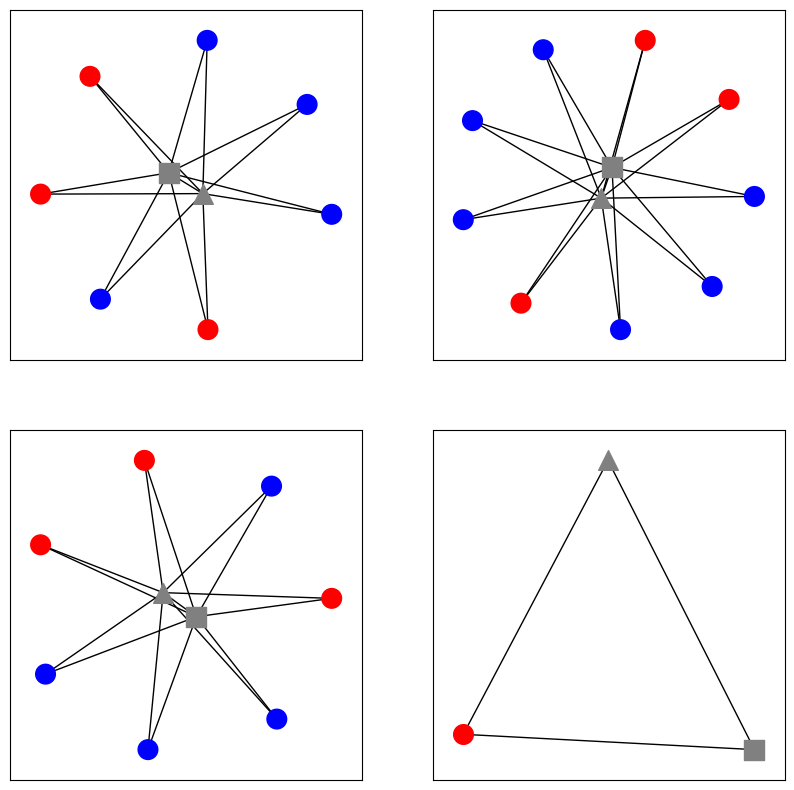

In [79]:
plot_neighborhood(dataloader_fraud, N_plots=4)